<a href="https://colab.research.google.com/github/inesNeji/Olive-Varieties-Classification-App/blob/main/Olive_Varieties_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Parameters
target_size = (128, 128)  # Input image size
batch_size = 32  # Batch size
epochs = 20  # Number of training epochs
dataset_path = '/content/drive/MyDrive/data_pfee'  # Update your dataset path

# Function to apply leaf segmentation
def segment_leaf(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    segmented = cv2.bitwise_and(image, image, mask=mask)
    return segmented

# Custom data generator with segmentation
class SegmentedImageDataGenerator(ImageDataGenerator):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, *args, **kwargs)
        while True:
            batch_x, batch_y = next(generator)
            batch_x_segmented = np.array([segment_leaf((x * 255).astype(np.uint8)) for x in batch_x]) / 255.0
            yield batch_x_segmented, batch_y

# Data augmentation and preprocessing
datagen = SegmentedImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Training and validation generators
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Enhanced CNN Architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[early_stopping, lr_scheduler])

# Save the model
model.save('leaf_classification_model.h5')

# Plot training performance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 5005 images belonging to 3 classes.
Epoch 1/20
  44983/Unknown 13537s 301ms/step - accuracy: 0.9254 - loss: 0.2041

In [ ]:
#cette partie est pour l'evaluation des performances du modèle sur les images de validation
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Charger le modèle entraîné
model = load_model('/content/drive/MyDrive/leaf_classification_model86.h5')

print("✅ Modèle chargé avec succès !")

# Define dataset path (same as during training)
dataset_dir = '/content/drive/MyDrive/dataset_pfe_converted'

# 🔹 Data augmentation & normalization (same parameters as training)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation
)

# Validation data generator
# Use the same target_size as during training
val_generator = datagen.flow_from_directory(
    dataset_dir, #path

    target_size=(128, 128), # Changed to (128, 128) to match training data

    batch_size=32,

    class_mode='categorical',

    subset='validation'
)

# Now you can evaluate the model:
loss, accuracy = model.evaluate(val_generator)
print(f"📊 Accuracy: {accuracy * 100:.2f}%")
print(f"📉 Loss: {loss:.4f}")

✅ Modèle chargé avec succès !
Found 1247 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 510s 13s/step - accuracy: 0.8695 - loss: 0.3994
📊 Accuracy: 86.61%
📉 Loss: 0.3965


# Transfer Learning Part

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Parameters
target_size = (224, 224)  # Input size required for EfficientNet
batch_size = 32
epochs = 20
dataset_path = '/content/drive/MyDrive/data_pfee'  # Update your path

# Function to apply leaf segmentation
def segment_leaf(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    segmented = cv2.bitwise_and(image, image, mask=mask)
    return segmented

# Custom Data Generator with Segmentation
class SegmentedImageDataGenerator(ImageDataGenerator):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, *args, **kwargs)
        while True:
            batch_x, batch_y = next(generator)
            batch_x_segmented = np.array([segment_leaf((x * 255).astype(np.uint8)) for x in batch_x]) / 255.0
            yield batch_x_segmented, batch_y

# Data Augmentation and Preprocessing
datagen = SegmentedImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Training and validation generators
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load Pre-trained Model (EfficientNetB0)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained layers

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(3, activation='softmax')(x)

# Define Model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[early_stopping, lr_scheduler])

# Save the model
model.save('leaf_classification_model_transfer_learning.h5')

# Plot training performance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EffecientNet

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = '/content/drive/MyDrive/data_pfee'  # Your dataset folder

# 1. Gather image paths and labels
class_names = sorted(os.listdir(DATA_DIR))
all_image_paths = []
all_labels = []

for label_index, class_name in enumerate(class_names):
    class_dir = os.path.join(DATA_DIR, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            all_image_paths.append(os.path.join(class_dir, fname))
            all_labels.append(label_index)

# 2. Train-validation split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

# 3. Segmentation function using OpenCV
def segment_leaf(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    segmented = cv2.bitwise_and(image, image, mask=mask)
    return segmented

# 4. Wrapper to apply OpenCV inside TensorFlow pipeline
def load_and_preprocess(path, label):
    def _load(path_str):
        path_str = path_str.decode()
        image = cv2.imread(path_str)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = segment_leaf(image)
        image = image.astype(np.float32) / 255.0
        return image

    image = tf.numpy_function(_load, [path], tf.float32)
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return image, tf.one_hot(label, depth=len(class_names))

# 5. Build tf.data.Dataset pipeline
def build_dataset(image_paths, labels, shuffle=True):
    path_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        path_ds = path_ds.shuffle(len(image_paths))
    ds = path_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = build_dataset(train_paths, train_labels, shuffle=True)
val_ds = build_dataset(val_paths, val_labels, shuffle=False)


In [ ]:
historyTr = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stopping, lr_scheduler])


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.3605 - loss: 1.1029 - val_accuracy: 0.3525 - val_loss: 1.0972 - learning_rate: 0.0010
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 93s 289ms/step - accuracy: 0.3611 - loss: 1.0986 - val_accuracy: 0.3549 - val_loss: 1.0957 - learning_rate: 0.0010
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 280ms/step - accuracy: 0.3704 - loss: 1.0949 - val_accuracy: 0.3525 - val_loss: 1.0956 - learning_rate: 0.0010
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 285ms/step - accuracy: 0.3518 - loss: 1.0957 - val_accuracy: 0.3525 - val_loss: 1.0950 - learning_rate: 0.0010
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 269ms/step - accuracy: 0.3546 - loss: 1.0951 - val_accuracy: 0.3549 - val_loss: 1.0949 - learning_rate: 0.0010
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 270ms/step - accuracy: 0.3569 - loss: 1.0925 - val_accuracy: 0.3549 - val_loss: 1.0948 - learning_rate: 0.0010
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - accuracy: 0.344

KeyboardInterrupt: 

## MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
historyTr = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stopping, lr_scheduler])


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 364ms/step - accuracy: 0.6538 - loss: 0.8077 - val_accuracy: 0.8537 - val_loss: 0.3630 - learning_rate: 0.0010
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 261ms/step - accuracy: 0.8385 - loss: 0.3946 - val_accuracy: 0.8769 - val_loss: 0.3054 - learning_rate: 0.0010
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 85s 277ms/step - accuracy: 0.8629 - loss: 0.3199 - val_accuracy: 0.8817 - val_loss: 0.2912 - learning_rate: 0.0010
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 279ms/step - accuracy: 0.8693 - loss: 0.3006 - val_accuracy: 0.9017 - val_loss: 0.2425 - learning_rate: 0.0010
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - accuracy: 0.9031 - loss: 0.2381 - val_accuracy: 0.9025 - val_loss: 0.2317 - learning_rate: 0.0010
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 263ms/step - accuracy: 0.9037 - loss: 0.2393 - val_accuracy: 0.9025 - val_loss: 0.2251 - learning_rate: 0.0010
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 271ms/step - accuracy: 0.9

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms

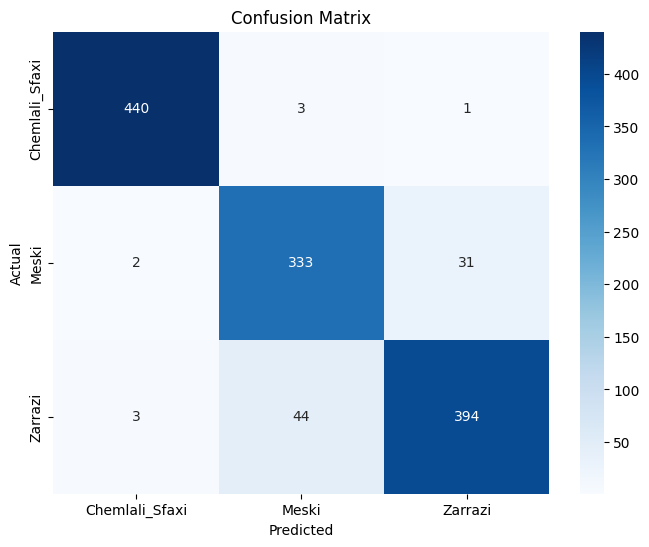

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions and true labels
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103m

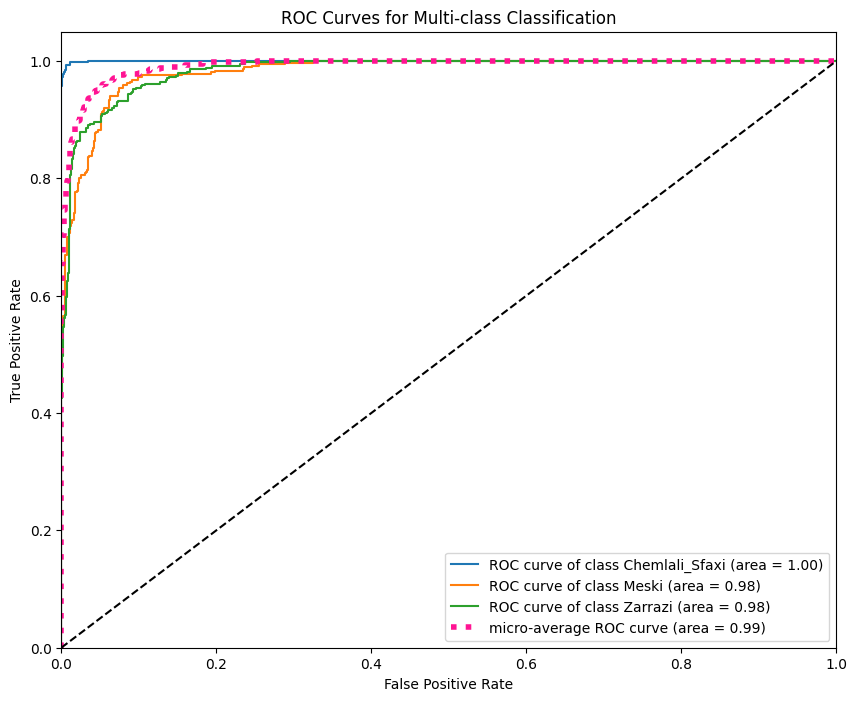

In [ ]:
# prompt: roc curve

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# ... (your existing code) ...

# Get predictions and true labels (make sure this part is executed before)
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(preds)  # Keep probability scores
    y_true.extend(np.argmax(labels.numpy(), axis=1))


# Binarize the output
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(y_pred)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), np.array(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()


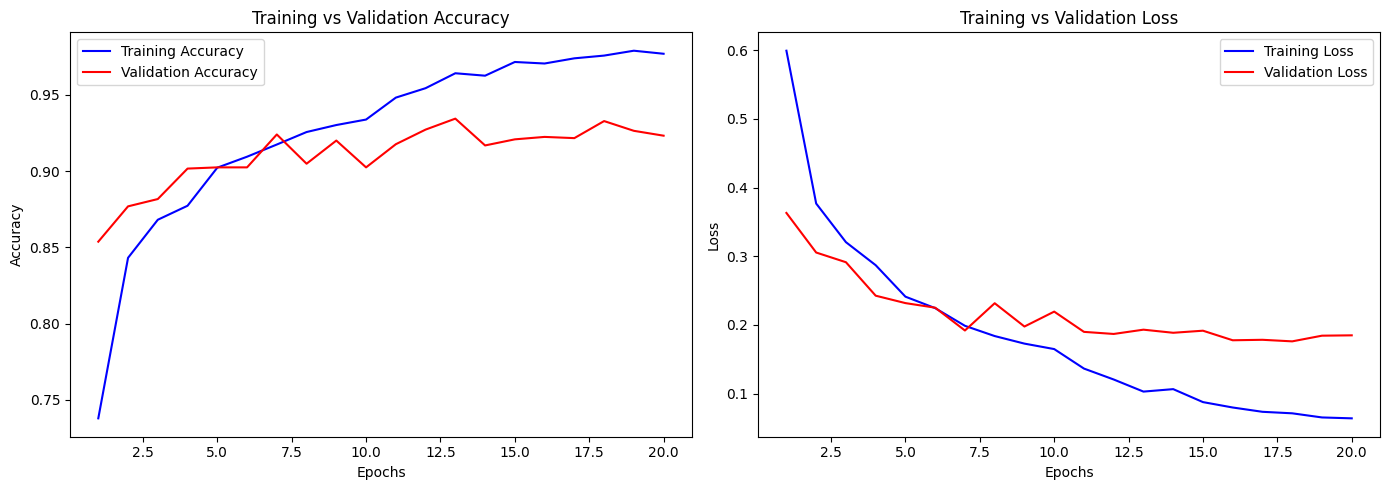

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    acc = historyTr.history['accuracy']
    val_acc = historyTr.history['val_accuracy']
    loss = historyTr.history['loss']
    val_loss = historyTr.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call this after training
plot_learning_curves(historyTr)


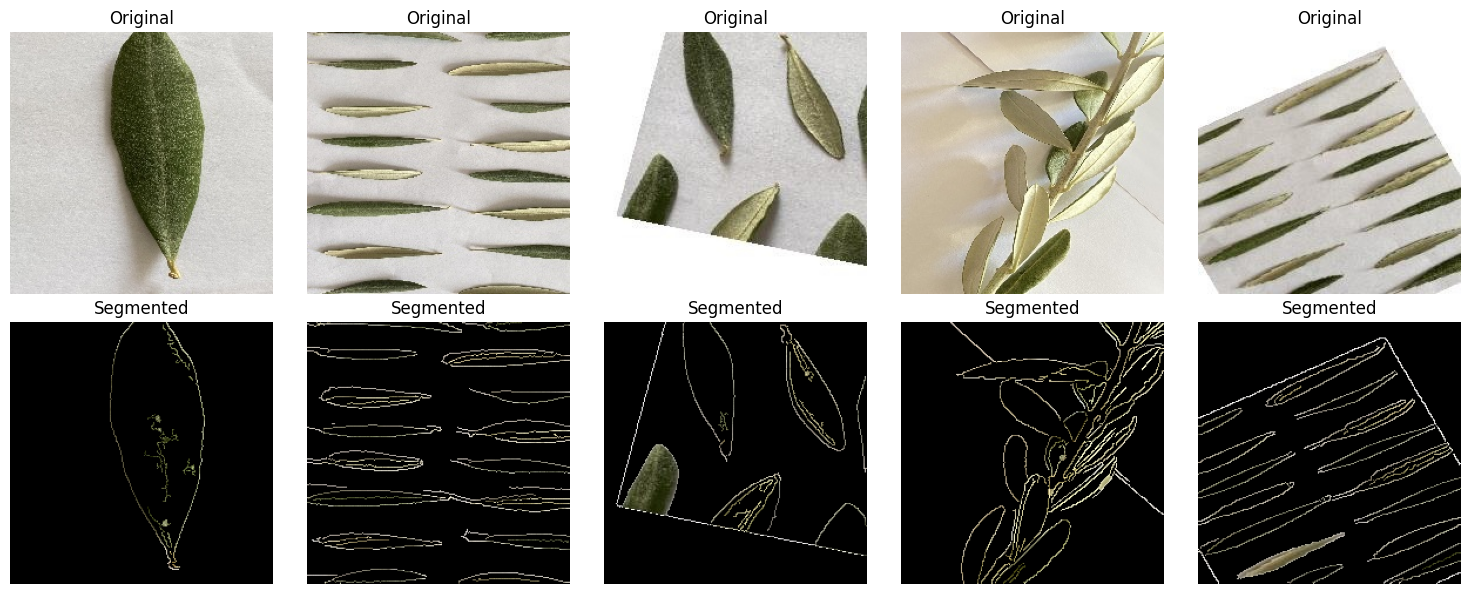

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import os

# Path to your dataset (raw images)
sample_class = random.choice(os.listdir(DATA_DIR))
sample_dir = os.path.join(DATA_DIR, sample_class)
sample_images = random.sample(os.listdir(sample_dir), 5)

def segment_leaf(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    segmented = cv2.bitwise_and(image, image, mask=mask)
    return segmented

plt.figure(figsize=(15, 6))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(sample_dir, img_name)
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, (224, 224))
    segmented = segment_leaf(img_rgb)

    # Original
    plt.subplot(2, len(sample_images), i + 1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis('off')

    # Segmented
    plt.subplot(2, len(sample_images), i + 1 + len(sample_images))
    plt.imshow(segmented)
    plt.title("Segmented")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# prompt: save the model as h5

# The model is already saved in the provided code:
model.save('leaf_classification_model_transfer_learning.h5')

# If you want to save it again with a different name, use:
# model.save('my_new_model.h5')
